In [3]:
! pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 22.0 MB/s eta 0:00:00


In [4]:
# import dependencies
import torch
from datasets import load_dataset
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm.notebook import tqdm
import random

In [5]:
# specify dataset name and model name
DATASET_PATH = "scikit-fingerprints/MoleculeNet_Lipophilicity"
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"  #MoLFormer model

# load the dataset from HuggingFace
dataset = load_dataset(DATASET_PATH)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

lipophilicity.csv:   0%|          | 0.00/223k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4200 [00:00<?, ? examples/s]

In [6]:
# define a PyTorch Dataset class for handling SMILES strings and targets

# TODO: your code goes here
class SMILESDataset(Dataset):

  def __init__(self, data, tokenizer, max_length):
      self.data = data
      self.tokenizer = tokenizer
      self.max_len = max_length

  def __len__(self):
      return len(self.data)

  def __getitem__(self, idx):
      row = self.data[idx]
      SMILES = row['SMILES']
      label = row['label']

      inputs = self.tokenizer.encode_plus(
      SMILES,
      add_special_tokens=True,
      max_length=self.max_len,
      padding='max_length',
      return_token_type_ids=False,
      truncation=True
  )

      return {
    'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
    'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
    'target': torch.tensor(label, dtype=torch.float)  # Directly convert the target to float
}



In [7]:
# tokenize the data
# load a pre-trained tokenizer from HuggingFace
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenization_molformer_fast.py:   0%|          | 0.00/6.50k [00:00<?, ?B/s]

tokenization_molformer.py:   0%|          | 0.00/9.48k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer_fast.py
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/41.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/54.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [8]:
# First, split the original 'train' split into train+validation and test (e.g., 80/20)
split_dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_valid_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

# Then, split train_valid_dataset into train and validation (e.g., 90/10 of train_valid_dataset)
split_train_valid = train_valid_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_train_valid["train"]
valid_dataset = split_train_valid["test"]

print("Train samples:", len(train_dataset))
print("Validation samples:", len(valid_dataset))
print("Test samples:", len(test_dataset))

Train samples: 3024
Validation samples: 336
Test samples: 840


In [9]:
reg_train_dataset = SMILESDataset(train_dataset, tokenizer, max_length=128)
reg_valid_dataset = SMILESDataset(valid_dataset, tokenizer, max_length=128)
reg_test_dataset  = SMILESDataset(test_dataset, tokenizer, max_length=128)

reg_train_loader = DataLoader(reg_train_dataset, batch_size=16, shuffle=True)
reg_valid_loader = DataLoader(reg_valid_dataset, batch_size=16, shuffle=False)
reg_test_loader  = DataLoader(reg_test_dataset, batch_size=16, shuffle=False)

In [11]:
# We need to add a regression head on the language model as we are doing a regression task.

# specify model with a regression head

class MoLFormerWithRegressionHead(nn.Module):
    # TODO: your code goes here
  def __init__(self,model):
    super().__init__()
    self.pretrained = model
    hidden_size = self.pretrained.config.hidden_size


    self.regression = nn.Linear(hidden_size, 1)


  def forward(self, ids, mask):
    # pass input to the pre-trained model
    output = self.pretrained(ids, attention_mask=mask)
    # extracts the last hidden state
    hidden_states = output.last_hidden_state
    # selects the cls token, represents the summary of the entire sequence
    cls_representation = hidden_states[:, 0, :]

    output = self.regression(cls_representation)
    return output.squeeze(-1) # to remove the last dimension



# helpful Functions for training and early stopping

In [16]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            min_delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def step(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return False

        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False


In [23]:
import torch
import torch.optim as optim
from tqdm import tqdm
import numpy as np

def train_model(model,reg_train_loader,reg_valid_loader,EPOCHS=20,LEARNING_RATE=1e-7,patience=5, min_delta=0.001):
    """
    Train the given model using LoRA (or standard) fine-tuning with early stopping and linear LR scheduler.

    Args:
        model (nn.Module): The model to train.
        reg_train_loader (DataLoader): Training data loader.
        reg_valid_loader (DataLoader): Validation data loader.
        EPOCHS (int): Number of epochs to train.
        LEARNING_RATE (float): Initial learning rate.
        patience (int): Patience for early stopping.
        min_delta (float): Minimum delta for early stopping improvement check.

    Returns:
        tuple: (train_loss_history, valid_loss_history)
    """

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define optimizer, scheduler, and loss function
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.0, total_iters=EPOCHS)
    loss_fn = torch.nn.MSELoss()

    # EarlyStopping is assumed to be a class you’ve defined or imported
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)

    # Lists to store losses for plotting
    train_loss_history = []
    valid_loss_history = []

    for epoch in range(EPOCHS):
        model.train()
        total_train_loss = 0.0

        # Training loop
        for batch in tqdm(reg_train_loader, desc=f"Epoch {epoch+1} Training"):
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            targets = batch['target'].to(device)

            optimizer.zero_grad()
            outputs = model(ids, mask)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * ids.size(0)

        scheduler.step()  # Update the learning rate at the end of each epoch

        avg_train_loss = total_train_loss / len(reg_train_loader.dataset)
        train_loss_history.append(avg_train_loss)
        print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}")

        # Validation loop
        model.eval()
        total_valid_loss = 0.0
        with torch.no_grad():
            for batch in tqdm(reg_valid_loader, desc=f"Epoch {epoch+1} Validation"):
                ids = batch['ids'].to(device)
                mask = batch['mask'].to(device)
                targets = batch['target'].to(device)

                outputs = model(ids, mask)
                loss = loss_fn(outputs, targets)
                total_valid_loss += loss.item() * ids.size(0)

        avg_valid_loss = total_valid_loss / len(reg_valid_loader.dataset)
        valid_loss_history.append(avg_valid_loss)
        print(f"Epoch {epoch+1} - Validation Loss: {np.sqrt(avg_valid_loss):.4f}")

        # Early stopping check
        if early_stopping.step(avg_valid_loss):
            print("Early stopping triggered")
            break

    # take sqrt to return RMSE instead of MSE
    return np.sqrt(train_loss_history), np.sqrt(valid_loss_history)


# Load the finetuned model from task 1

In [42]:
import torch
import zipfile
from google.colab import drive


drive.mount('/content/drive', force_remount=True)
# Specify the path to your zipped model file in Google Drive
zip_file_path = '/content/drive/My Drive/Colab Notebooks/mlm_finetuned_model.zip'
extract_path = '/content/extracted_model'


# Extract the zipped model
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

model = AutoModel.from_pretrained(f'{extract_path}/mlm_finetuned_model', trust_remote_code=True)


Mounted at /content/drive


In [44]:
# initialize the regression model with the added regression layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model = MoLFormerWithRegressionHead(model).to(device)

# Full finetuning

In [51]:
# here tuning all weights and biases of the model before applying any approaches

In [54]:
model = AutoModel.from_pretrained(f'{extract_path}/mlm_finetuned_model', trust_remote_code=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model = MoLFormerWithRegressionHead(model).to(device)

In [55]:
train_losses, val_losses = train_model(
    model=regression_model,
    reg_train_loader=reg_train_loader,
    reg_valid_loader=reg_valid_loader,
    EPOCHS=20,
    LEARNING_RATE=1e-7,
    patience=5,
    min_delta=0.001
)

Epoch 1 Training: 100%|██████████| 189/189 [00:38<00:00,  4.85it/s]


Epoch 1 - Training Loss: 6.5043


Epoch 1 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.96it/s]


Epoch 1 - Validation Loss: 6.3070


Epoch 2 Training: 100%|██████████| 189/189 [00:38<00:00,  4.92it/s]


Epoch 2 - Training Loss: 5.5811


Epoch 2 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.04it/s]


Epoch 2 - Validation Loss: 5.3867


Epoch 3 Training: 100%|██████████| 189/189 [00:38<00:00,  4.93it/s]


Epoch 3 - Training Loss: 4.7949


Epoch 3 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.81it/s]


Epoch 3 - Validation Loss: 4.5968


Epoch 4 Training: 100%|██████████| 189/189 [00:38<00:00,  4.91it/s]


Epoch 4 - Training Loss: 4.1180


Epoch 4 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.16it/s]


Epoch 4 - Validation Loss: 4.0059


Epoch 5 Training: 100%|██████████| 189/189 [00:38<00:00,  4.92it/s]


Epoch 5 - Training Loss: 3.5651


Epoch 5 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.29it/s]


Epoch 5 - Validation Loss: 3.4552


Epoch 6 Training: 100%|██████████| 189/189 [00:38<00:00,  4.92it/s]


Epoch 6 - Training Loss: 3.0851


Epoch 6 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.24it/s]


Epoch 6 - Validation Loss: 2.9796


Epoch 7 Training: 100%|██████████| 189/189 [00:38<00:00,  4.92it/s]


Epoch 7 - Training Loss: 2.7062


Epoch 7 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.42it/s]


Epoch 7 - Validation Loss: 2.5789


Epoch 8 Training: 100%|██████████| 189/189 [00:38<00:00,  4.92it/s]


Epoch 8 - Training Loss: 2.4101


Epoch 8 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.33it/s]


Epoch 8 - Validation Loss: 2.3140


Epoch 9 Training: 100%|██████████| 189/189 [00:38<00:00,  4.91it/s]


Epoch 9 - Training Loss: 2.1629


Epoch 9 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.22it/s]


Epoch 9 - Validation Loss: 2.0943


Epoch 10 Training: 100%|██████████| 189/189 [00:38<00:00,  4.92it/s]


Epoch 10 - Training Loss: 1.9850


Epoch 10 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.30it/s]


Epoch 10 - Validation Loss: 1.9145


Epoch 11 Training: 100%|██████████| 189/189 [00:38<00:00,  4.92it/s]


Epoch 11 - Training Loss: 1.8394


Epoch 11 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.28it/s]


Epoch 11 - Validation Loss: 1.7713


Epoch 12 Training: 100%|██████████| 189/189 [00:38<00:00,  4.92it/s]


Epoch 12 - Training Loss: 1.7195


Epoch 12 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.32it/s]


Epoch 12 - Validation Loss: 1.6761


Epoch 13 Training: 100%|██████████| 189/189 [00:38<00:00,  4.92it/s]


Epoch 13 - Training Loss: 1.6765


Epoch 13 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.12it/s]


Epoch 13 - Validation Loss: 1.6090


Epoch 14 Training: 100%|██████████| 189/189 [00:38<00:00,  4.92it/s]


Epoch 14 - Training Loss: 1.6184


Epoch 14 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.87it/s]


Epoch 14 - Validation Loss: 1.6039


Epoch 15 Training: 100%|██████████| 189/189 [00:38<00:00,  4.91it/s]


Epoch 15 - Training Loss: 1.5753


Epoch 15 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.97it/s]


Epoch 15 - Validation Loss: 1.5199


Epoch 16 Training: 100%|██████████| 189/189 [00:38<00:00,  4.92it/s]


Epoch 16 - Training Loss: 1.5709


Epoch 16 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.33it/s]


Epoch 16 - Validation Loss: 1.5173


Epoch 17 Training: 100%|██████████| 189/189 [00:38<00:00,  4.92it/s]


Epoch 17 - Training Loss: 1.5333


Epoch 17 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.19it/s]


Epoch 17 - Validation Loss: 1.4711


Epoch 18 Training: 100%|██████████| 189/189 [00:38<00:00,  4.91it/s]


Epoch 18 - Training Loss: 1.5354


Epoch 18 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.25it/s]


Epoch 18 - Validation Loss: 1.4504


Epoch 19 Training: 100%|██████████| 189/189 [00:38<00:00,  4.92it/s]


Epoch 19 - Training Loss: 1.5324


Epoch 19 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.27it/s]


Epoch 19 - Validation Loss: 1.4805


Epoch 20 Training: 100%|██████████| 189/189 [00:38<00:00,  4.92it/s]


Epoch 20 - Training Loss: 1.5097


Epoch 20 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.51it/s]

Epoch 20 - Validation Loss: 1.4812


# plot training and validation losses using full finetuning

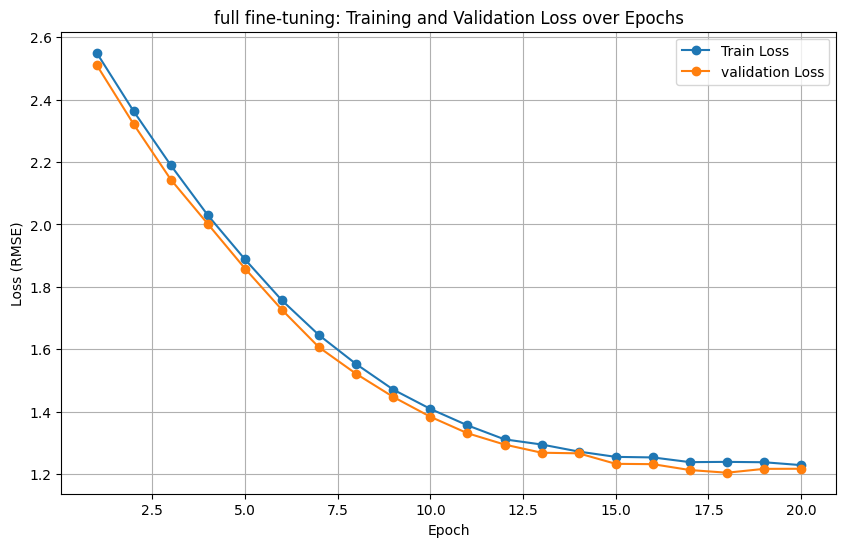

In [56]:
import matplotlib.pyplot as plt


epochs = list(range(1, len(train_losses)+1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (RMSE)')
plt.title('full fine-tuning: Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.savefig("Full finetuning RMSE.png")
plt.show()

# Test the full fine-tuning approach on the test set

In [57]:
regression_model.eval()
loss_fn = torch.nn.MSELoss()

total_test_loss = 0.0
with torch.no_grad():
    for batch in tqdm(reg_test_loader, desc="Testing"):
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['target'].to(device)

        outputs = regression_model(ids, mask)
        loss = loss_fn(outputs, targets)
        total_test_loss += loss.item() * ids.size(0)

avg_test_loss = total_test_loss / len(reg_test_loader.dataset)
print(f"Test Loss RMSE: {np.sqrt(avg_test_loss):.4f}")

Testing: 100%|██████████| 53/53 [00:03<00:00, 13.44it/s]

Test Loss RMSE: 1.1948


# 3_2_1: Finetuning  using bitfit

In [44]:
model = AutoModel.from_pretrained(f'{extract_path}/mlm_finetuned_model', trust_remote_code=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model = MoLFormerWithRegressionHead(model).to(device)

In [45]:
#Freeze all non-bias parameters
for name, param in regression_model.named_parameters():
    if 'bias' in name:
        param.requires_grad = True   # Allow training for bias terms
    else:
        param.requires_grad = False  # Freeze all other parameters


In [46]:
train_losses, val_losses = train_model(
    model=regression_model,
    reg_train_loader=reg_train_loader,
    reg_valid_loader=reg_valid_loader,
    EPOCHS=20,
    LEARNING_RATE=1e-7,
    patience=5,
    min_delta=0.001
)

Epoch 1 Training: 100%|██████████| 189/189 [00:28<00:00,  6.57it/s]


Epoch 1 - Training Loss: 5.4803


Epoch 1 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.46it/s]


Epoch 1 - Validation Loss: 5.7669


Epoch 2 Training: 100%|██████████| 189/189 [00:29<00:00,  6.47it/s]


Epoch 2 - Training Loss: 5.4334


Epoch 2 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.84it/s]


Epoch 2 - Validation Loss: 5.6961


Epoch 3 Training: 100%|██████████| 189/189 [00:28<00:00,  6.67it/s]


Epoch 3 - Training Loss: 5.4094


Epoch 3 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.25it/s]


Epoch 3 - Validation Loss: 5.7747


Epoch 4 Training: 100%|██████████| 189/189 [00:30<00:00,  6.30it/s]


Epoch 4 - Training Loss: 5.4050


Epoch 4 Validation: 100%|██████████| 21/21 [00:02<00:00,  9.42it/s]


Epoch 4 - Validation Loss: 5.7105


Epoch 5 Training: 100%|██████████| 189/189 [00:28<00:00,  6.63it/s]


Epoch 5 - Training Loss: 5.4113


Epoch 5 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.45it/s]


Epoch 5 - Validation Loss: 5.7160


Epoch 6 Training: 100%|██████████| 189/189 [00:29<00:00,  6.44it/s]


Epoch 6 - Training Loss: 5.3898


Epoch 6 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.86it/s]


Epoch 6 - Validation Loss: 5.6203


Epoch 7 Training: 100%|██████████| 189/189 [00:29<00:00,  6.31it/s]


Epoch 7 - Training Loss: 5.3676


Epoch 7 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.17it/s]


Epoch 7 - Validation Loss: 5.7079


Epoch 8 Training: 100%|██████████| 189/189 [00:28<00:00,  6.71it/s]


Epoch 8 - Training Loss: 5.3266


Epoch 8 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.44it/s]


Epoch 8 - Validation Loss: 5.6698


Epoch 9 Training: 100%|██████████| 189/189 [00:29<00:00,  6.40it/s]


Epoch 9 - Training Loss: 5.3300


Epoch 9 Validation: 100%|██████████| 21/21 [00:01<00:00, 11.21it/s]


Epoch 9 - Validation Loss: 5.6301


Epoch 10 Training: 100%|██████████| 189/189 [00:29<00:00,  6.35it/s]


Epoch 10 - Training Loss: 5.3125


Epoch 10 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.44it/s]


Epoch 10 - Validation Loss: 5.6238


Epoch 11 Training: 100%|██████████| 189/189 [00:29<00:00,  6.47it/s]


Epoch 11 - Training Loss: 5.2865


Epoch 11 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.95it/s]


Epoch 11 - Validation Loss: 5.5251


Epoch 12 Training: 100%|██████████| 189/189 [00:29<00:00,  6.43it/s]


Epoch 12 - Training Loss: 5.2895


Epoch 12 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.78it/s]


Epoch 12 - Validation Loss: 5.5929


Epoch 13 Training: 100%|██████████| 189/189 [00:28<00:00,  6.63it/s]


Epoch 13 - Training Loss: 5.2903


Epoch 13 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.95it/s]


Epoch 13 - Validation Loss: 5.5410


Epoch 14 Training: 100%|██████████| 189/189 [00:28<00:00,  6.61it/s]


Epoch 14 - Training Loss: 5.2790


Epoch 14 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.87it/s]


Epoch 14 - Validation Loss: 5.5644


Epoch 15 Training: 100%|██████████| 189/189 [00:28<00:00,  6.60it/s]


Epoch 15 - Training Loss: 5.2616


Epoch 15 Validation: 100%|██████████| 21/21 [00:01<00:00, 11.04it/s]


Epoch 15 - Validation Loss: 5.5832


Epoch 16 Training: 100%|██████████| 189/189 [00:27<00:00,  6.78it/s]


Epoch 16 - Training Loss: 5.2521


Epoch 16 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.04it/s]


Epoch 16 - Validation Loss: 5.4686


Epoch 17 Training: 100%|██████████| 189/189 [00:27<00:00,  6.78it/s]


Epoch 17 - Training Loss: 5.2255


Epoch 17 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.23it/s]


Epoch 17 - Validation Loss: 5.5884


Epoch 18 Training: 100%|██████████| 189/189 [00:27<00:00,  6.78it/s]


Epoch 18 - Training Loss: 5.2615


Epoch 18 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.32it/s]


Epoch 18 - Validation Loss: 5.5269


Epoch 19 Training: 100%|██████████| 189/189 [00:29<00:00,  6.48it/s]


Epoch 19 - Training Loss: 5.2384


Epoch 19 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.19it/s]


Epoch 19 - Validation Loss: 5.4976


Epoch 20 Training: 100%|██████████| 189/189 [00:29<00:00,  6.37it/s]


Epoch 20 - Training Loss: 5.2798


Epoch 20 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.84it/s]

Epoch 20 - Validation Loss: 5.5004


# Plot training and validation of BitFit

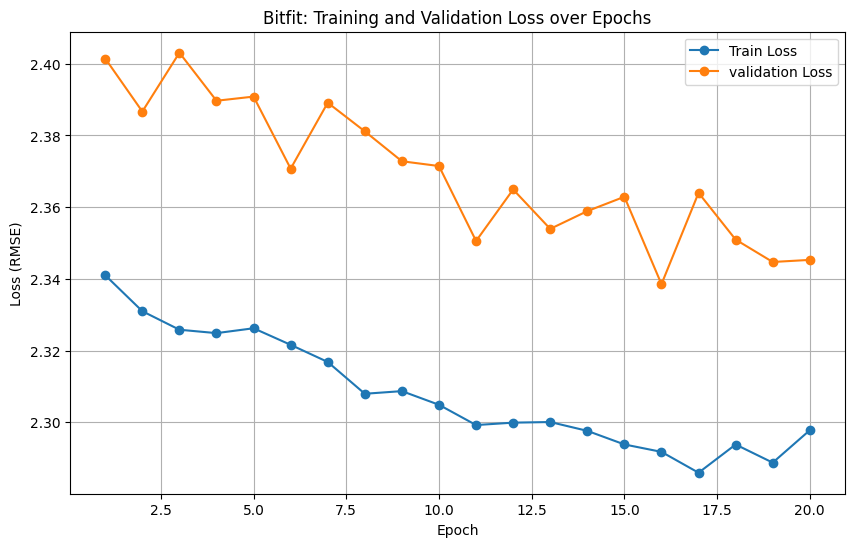

In [48]:
import matplotlib.pyplot as plt


epochs = list(range(1, len(train_losses)+1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (RMSE)')
plt.title('Bitfit: Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.savefig("BitFit RMSE.png")
plt.show()

# test the BitFit approach on the test set

In [49]:
regression_model.eval()
loss_fn = torch.nn.MSELoss()

total_test_loss = 0.0
with torch.no_grad():
    for batch in tqdm(reg_test_loader, desc="Testing"):
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['target'].to(device)

        outputs = regression_model(ids, mask)
        loss = loss_fn(outputs, targets)
        total_test_loss += loss.item() * ids.size(0)

avg_test_loss = total_test_loss / len(reg_test_loader.dataset)
print(f"Test Loss RMSE: {np.sqrt(avg_test_loss):.4f}")

Testing: 100%|██████████| 53/53 [00:03<00:00, 13.45it/s]

Test Loss RMSE: 2.2588


# 3_2_2 Implement Finetuning using LoRa

In [12]:
class LORALayer():
  def __init__(self, rank, alpha=1 ,dropout=0 ):
      self.rank= rank
      self.alpha= alpha
      self.dropout= nn.Dropout(p=dropout)

      self.scaling= self.alpha / self.rank



class Lora_Linear(nn.Linear, LORALayer): # inherits from both
  def __init__(self, in_features, out_features,rank =0,alpha=1,dropout=0, bias= True ):
    nn.Linear.__init__(self, in_features, out_features)
    LORALayer.__init__(self, rank, alpha, dropout)

    if rank>0:
      self.A =  nn.Parameter(self.weight.new_zeros((rank, in_features)))

      self.B =  nn.Parameter(self.weight.new_zeros((out_features,  rank)))

      # Freezing the pre-trained weight matrix
      self.weight.requires_grad = False

      # as per the paper, they initialized B with zeros and initialized A with Random gaussian.
      nn.init.normal_(self.A, mean=0.0, std=0.02)
      nn.init.zeros_(self.B)

  def forward(self, input):
    if self.rank >0:
      result = nn.functional.linear(input, self.weight, self.bias)
      result += (self.dropout(input) @ self.A.t() @ self.B.t() * self.scaling)
      return result

    else:
      return nn.functional.linear(input, self.weight, self.bias)









In [13]:
# function for iterating on the layers and apply lora on the attention layers
def replace_layer_with_lora( model,  rank, alpha , dropout,target_keywords=["query", "key", "value"]):

  for name,layer in model.named_children():

    # check if the next layer is instance of nn.Linear
    if isinstance(layer , nn.Linear):

      if target_keywords is None or any(kw in name for kw in target_keywords):


        # Create our LoRA-enabled linear layer with matching dimensions.
        lora_layer = Lora_Linear(
            in_features=layer.in_features,
            out_features=layer.out_features,
            rank=rank,
            alpha=alpha,
            dropout=dropout,
            bias=(layer.bias is not None)
        )

        # Copy over the original weights (and bias if available).
        lora_layer.weight.data = layer.weight.data.clone()
        if layer.bias is not None:
            lora_layer.bias = layer.bias
        # Replace the old layer with our new LoRA layer.
        setattr(model, name, lora_layer)
    else:
        # Recursively replace in child layer modules.
        replace_layer_with_lora(layer, rank, alpha, dropout ,target_keywords)



In [14]:
class MoLFormerWithRegression_Lora(nn.Module):
    def __init__(self, model, rank, alpha, lora_dropout=0.1):
        super().__init__()
        self.pretrained = model

        # apply LoRA to selected layers in the pretrained model.
        # the target layers with names that include "query", "key", or "value" (attention layers)

        target_keywords = ["query", "key", "value"]
        replace_layer_with_lora(self.pretrained,
                                 rank=rank, alpha=alpha, dropout=lora_dropout, target_keywords=target_keywords)

        hidden_size = self.pretrained.config.hidden_size

        # Replace the standard regression head with a LoRA-enabled linear layer.
        self.regression = Lora_Linear(
            in_features=hidden_size,
            out_features=1,
            rank=rank,
            alpha=alpha,
            dropout=lora_dropout,
        )

    def forward(self, ids, mask):
        # Pass the input through the pretrained model.
        outputs = self.pretrained(ids, attention_mask=mask)
        hidden_states = outputs.last_hidden_state
        # Use the first token ([CLS] token) as the summary representation.
        cls_representation = hidden_states[:, 0, :]
        # Get the regression output using our LoRA-enhanced head.
        output = self.regression(cls_representation)
        return output.squeeze(-1)  # Remove the last dimension for a scalar output



# Load the finetuned model from task1

In [37]:
import torch
import zipfile
from google.colab import drive


drive.mount('/content/drive', force_remount=True)
# Specify the path to your zipped model file in Google Drive
zip_file_path = '/content/drive/My Drive/Colab Notebooks/mlm_finetuned_model.zip'
extract_path = '/content/extracted_model'


# Extract the zipped model
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

model = AutoModel.from_pretrained(f'{extract_path}/mlm_finetuned_model', trust_remote_code=True)


# Apply finetuning using Lora

In [38]:
# Load the base model and tokenizer from Hugging Face.
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
#model = AutoModel.from_pretrained(MODEL_NAME, deterministic_eval=True, trust_remote_code=True)
# Create an instance of our model with LoRA applied to both the pretrained layers and the regression head.
model = MoLFormerWithRegression_Lora(model, rank=4, alpha=8, lora_dropout=0.1)


In [39]:
train_losses, val_losses = train_model(
    model=model,
    reg_train_loader=reg_train_loader,
    reg_valid_loader=reg_valid_loader,
    EPOCHS=20,
    LEARNING_RATE=1e-7,
    patience=5,
    min_delta=0.001
)



Epoch 1 Training: 100%|██████████| 189/189 [00:39<00:00,  4.77it/s]


Epoch 1 - Training Loss: 3.6922


Epoch 1 Validation: 100%|██████████| 21/21 [00:01<00:00, 11.76it/s]


Epoch 1 - Validation Loss: 3.5475


Epoch 2 Training: 100%|██████████| 189/189 [00:39<00:00,  4.83it/s]


Epoch 2 - Training Loss: 3.3383


Epoch 2 Validation: 100%|██████████| 21/21 [00:02<00:00,  8.64it/s]


Epoch 2 - Validation Loss: 3.2536


Epoch 3 Training: 100%|██████████| 189/189 [00:39<00:00,  4.81it/s]


Epoch 3 - Training Loss: 3.0546


Epoch 3 Validation: 100%|██████████| 21/21 [00:01<00:00, 11.58it/s]


Epoch 3 - Validation Loss: 2.9574


Epoch 4 Training: 100%|██████████| 189/189 [00:39<00:00,  4.82it/s]


Epoch 4 - Training Loss: 2.7746


Epoch 4 Validation: 100%|██████████| 21/21 [00:01<00:00, 11.92it/s]


Epoch 4 - Validation Loss: 2.7331


Epoch 5 Training: 100%|██████████| 189/189 [00:39<00:00,  4.81it/s]


Epoch 5 - Training Loss: 2.5634


Epoch 5 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.02it/s]


Epoch 5 - Validation Loss: 2.5327


Epoch 6 Training: 100%|██████████| 189/189 [00:39<00:00,  4.82it/s]


Epoch 6 - Training Loss: 2.3987


Epoch 6 Validation: 100%|██████████| 21/21 [00:01<00:00, 11.84it/s]


Epoch 6 - Validation Loss: 2.3070


Epoch 7 Training: 100%|██████████| 189/189 [00:39<00:00,  4.82it/s]


Epoch 7 - Training Loss: 2.2533


Epoch 7 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.00it/s]


Epoch 7 - Validation Loss: 2.2038


Epoch 8 Training: 100%|██████████| 189/189 [00:39<00:00,  4.83it/s]


Epoch 8 - Training Loss: 2.1514


Epoch 8 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.19it/s]


Epoch 8 - Validation Loss: 2.0835


Epoch 9 Training: 100%|██████████| 189/189 [00:39<00:00,  4.83it/s]


Epoch 9 - Training Loss: 2.0243


Epoch 9 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.20it/s]


Epoch 9 - Validation Loss: 1.9667


Epoch 10 Training: 100%|██████████| 189/189 [00:38<00:00,  4.85it/s]


Epoch 10 - Training Loss: 1.9627


Epoch 10 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.23it/s]


Epoch 10 - Validation Loss: 1.9085


Epoch 11 Training: 100%|██████████| 189/189 [00:41<00:00,  4.58it/s]


Epoch 11 - Training Loss: 1.8865


Epoch 11 Validation: 100%|██████████| 21/21 [00:02<00:00, 10.08it/s]


Epoch 11 - Validation Loss: 1.8476


Epoch 12 Training: 100%|██████████| 189/189 [00:39<00:00,  4.77it/s]


Epoch 12 - Training Loss: 1.8451


Epoch 12 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.15it/s]


Epoch 12 - Validation Loss: 1.7580


Epoch 13 Training: 100%|██████████| 189/189 [00:38<00:00,  4.86it/s]


Epoch 13 - Training Loss: 1.7996


Epoch 13 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.20it/s]


Epoch 13 - Validation Loss: 1.7642


Epoch 14 Training: 100%|██████████| 189/189 [00:39<00:00,  4.81it/s]


Epoch 14 - Training Loss: 1.7762


Epoch 14 Validation: 100%|██████████| 21/21 [00:02<00:00, 10.06it/s]


Epoch 14 - Validation Loss: 1.7085


Epoch 15 Training: 100%|██████████| 189/189 [00:38<00:00,  4.85it/s]


Epoch 15 - Training Loss: 1.7350


Epoch 15 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.02it/s]


Epoch 15 - Validation Loss: 1.6994


Epoch 16 Training: 100%|██████████| 189/189 [00:40<00:00,  4.65it/s]


Epoch 16 - Training Loss: 1.7010


Epoch 16 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.22it/s]


Epoch 16 - Validation Loss: 1.6839


Epoch 17 Training: 100%|██████████| 189/189 [00:38<00:00,  4.85it/s]


Epoch 17 - Training Loss: 1.7007


Epoch 17 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.04it/s]


Epoch 17 - Validation Loss: 1.6553


Epoch 18 Training: 100%|██████████| 189/189 [00:38<00:00,  4.86it/s]


Epoch 18 - Training Loss: 1.6910


Epoch 18 Validation: 100%|██████████| 21/21 [00:01<00:00, 11.78it/s]


Epoch 18 - Validation Loss: 1.6456


Epoch 19 Training: 100%|██████████| 189/189 [00:40<00:00,  4.69it/s]


Epoch 19 - Training Loss: 1.6666


Epoch 19 Validation: 100%|██████████| 21/21 [00:01<00:00, 11.19it/s]


Epoch 19 - Validation Loss: 1.6099


Epoch 20 Training: 100%|██████████| 189/189 [00:39<00:00,  4.75it/s]


Epoch 20 - Training Loss: 1.6614


Epoch 20 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.14it/s]

Epoch 20 - Validation Loss: 1.6278


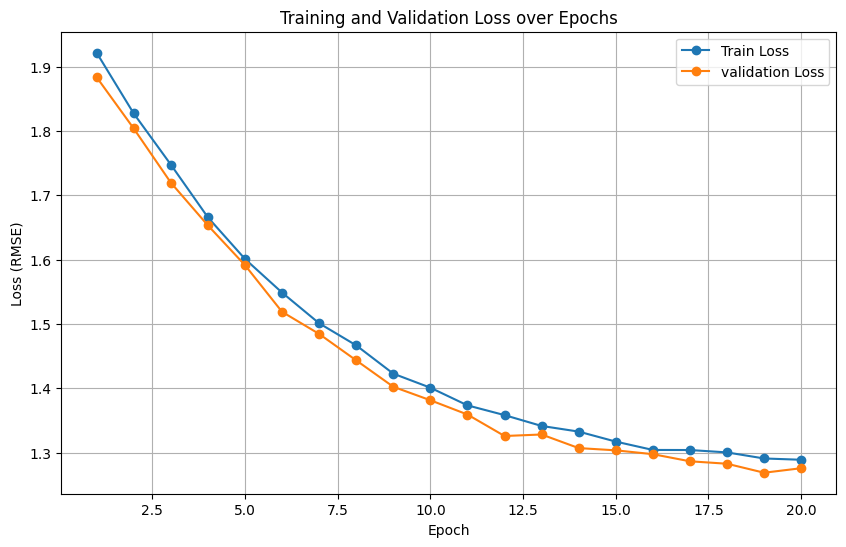

In [40]:
import matplotlib.pyplot as plt


epochs = list(range(1, len(train_losses)+1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (RMSE)')
plt.title('Lora Finetuning: Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.savefig("Lora RMSE.png")
plt.show()

In [ ]:
#

# testing the approach on the test set

In [41]:
model.eval()
loss_fn = torch.nn.MSELoss()

total_test_loss = 0.0
with torch.no_grad():
    for batch in tqdm(reg_test_loader, desc="Testing"):
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['target'].to(device)

        outputs = model(ids, mask)
        loss = loss_fn(outputs, targets)
        total_test_loss += loss.item() * ids.size(0)

avg_test_loss = total_test_loss / len(reg_test_loader.dataset)
print(f"Test Loss RMSE: {np.sqrt(avg_test_loss):.4f}")

Testing: 100%|██████████| 53/53 [00:04<00:00, 12.23it/s]

Test Loss RMSE: 1.2403
